# I. Setup 
- import statements, loading subject demographics, all functions for statistical analyses and figure generation

### A. Import Statements

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import ttest_ind
from statannot import add_stat_annotation

import warnings
warnings.filterwarnings('ignore')

### B. Load in gender and age info of each subject

In [2]:
# read in average ICD values
gender_age_data = pd.read_csv('data/subject_demographics_595.txt',sep = '\t',names = ['subj_ID','age_months','gender'])
# display first 20 data values to check that read-in was successful
gender_age_data.head(5)

,subj_ID,age_months,gender
0,HCA6030645,544,F
1,HCA6031344,967,F
2,HCA6037457,880,F
3,HCA6051047,725,F
4,HCA6053758,437,F


### C. conn_vs_age_plot function:  
> displays visualization of connectivity values vs age linear and quadratic regression for each subject by gender, where red indicates women and blue indicates men; jointplots also generated to show datapoint distribution

inputs: 
- **df:** pandas dataframe containing columns for subject ID, age, gender, and columns for each ROI that connectivity values were collected for
- **y:** string variable stating the name of the ROI of interest
- **avg_or_peak:** string variable stating whether connectivity value inputs are "avg" or "peak" values from the VOI stats computation operation in BioImageSuite
- **icd_or_seed:** string variable stating whether connectivity value inputs were derived from ICD or seed connectivity analysis

outputs:
- **figures** for linear and quadratic regressions, as well as jointplots, are saved into the directory specified within the function
- no variable outputs


In [3]:
def conn_vs_age_plot(df, y, avg_or_peak, icd_or_seed):
    sns.set(font_scale = 2)
    palette = sns.color_palette("bright")
    sns.set_style("white")
    
    # generate linear regression plots (with the y axis stretched by a factor of 2)
    linear_lmplot = sns.lmplot(data = df, x = 'age', y = y, hue = 'gender', palette = [palette[3],palette[0]], 
                               scatter_kws = {"alpha": 0.5}, line_kws={"alpha":1,"lw":7}, height=12, aspect=0.5, legend=False)
    
    plt.xticks([30,40,50,60,70,80,90,100])
    plt.ylabel("average ICD values")
    plt.title(y)
    plt.savefig("figures/lmplots/fig5_" + icd_or_seed + "_linear_" + y + ".png")
    return linear_lmplot

### D. get_linear_r_p function:  
> collects Pearson correlation (R) values and corresponding p values for linear fits for each gender in the input ROI

inputs: 
- **df:** pandas dataframe containing columns for subject ID, age, gender, and columns for each ROI that connectivity values were collected for
- **y:** string variable stating the name of the ROI of interest
- **avg_or_peak:** string variable stating whether connectivity value inputs are "avg" or "peak" values from the VOI stats computation operation in BioImageSuite
- **icd_or_seed:** string variable stating whether connectivity value inputs were derived from ICD or seed connectivity analysis

outputs:
- **r_f:** R for female linear regression in input ROI
- **p_f:** p value for female linear regression in input ROI
- **r_m:** R for male linear regression in input ROI
- **p_m:** p value for male linear regression in input ROI

In [4]:
def get_linear_r_p(df, y, avg_or_peak, icd_or_seed):
    r_f, p_f = sp.stats.pearsonr(df[df['gender'] == 'F']['age'], df[df['gender'] == 'F'][y])
    r_m, p_m = sp.stats.pearsonr(df[df['gender'] == 'M']['age'], df[df['gender'] == 'M'][y])
    return r_f, p_f, r_m, p_m

### E. get_lin_data function:  

> collects linear fit correlation data for each gender in the input ROI; implements *get_linear_r_p* function

inputs: 
- **df:** pandas dataframe containing columns for subject ID, age, gender, and columns for each ROI that connectivity values were collected for
- **ROI:** string variable stating the name of the ROI of interest
- **ROI_num:** integer variable stating the number of the ROI of interest (corresponds with ROI number label in BIS objectmap)
- **avg_or_peak:** string variable stating whether connectivity value inputs are "avg" or "peak" values from the VOI stats computation operation in BioImageSuite
- **icd_or_seed:** string variable stating whether connectivity value inputs were derived from ICD or seed connectivity analysis

outputs:
- **results:** pandas dataframe row holding the linear fit R and p values for each gender

In [5]:
def get_lin_data(df, ROI, ROI_num, avg_or_peak, icd_or_seed):
    lin_R_f, lin_p_f, lin_R_m, lin_p_m = get_linear_r_p(df, ROI, avg_or_peak, icd_or_seed)
    results = {'ROI_name':ROI, 'ROI_number':ROI_num,
               'linear_R_F':lin_R_f, 'linear_p_F':lin_p_f,
               'linear_R_M':lin_R_m, 'linear_p_M':lin_p_m}
    
    return results

### F. conn_vs_age_boxplot function:  

> visualize connectivity data by decade comparing F vs M subjects for the input ROI; also displays mean of each group with green triangles and dashed lines connecting mean values across decades for each gender

inputs: 
- **df:** pandas dataframe containing columns for subject ID, age, gender, and columns for each ROI that connectivity values were collected for
- **y:** string variable stating the name of the ROI of interest
- **avg_or_peak:** string variable stating whether connectivity value inputs are "avg" or "peak" values from the VOI stats computation operation in BioImageSuite
- **icd_or_seed:** string variable stating whether connectivity value inputs were derived from ICD or seed connectivity analysis
- **box_pair_list:** list of every comparison that the user wants displayed in the final figure (defined outside of this function, allows for exclusion of non-significant difference indicators)

outputs:
- **figures** of generated boxplots of women and men side by side, also shows the mean (as green triangles) on top of boxplots
- no variable outputs

In [6]:
def conn_vs_age_boxplot(df, y, icd_or_seed, box_pair_list):
    df["age groups"] = pd.cut(df["age"], bins = range(30, 101, 10))
    
    gender_list = sorted(df['gender'].unique())
    age_group_list = sorted(df['age groups'].unique())
    
    df_F = df[df['gender'] == 'F']
    df_M = df[df['gender'] == 'M']
    m_F = df_F.groupby('age groups')[y].mean()
    m_M = df_M.groupby('age groups')[y].mean()

    sns.set(font_scale = 4) # for main fig
    palette = sns.color_palette("bright")
    sns.set_style("whitegrid")
    fig = sns.boxplot(data = df, x = "age groups", y = y, hue = "gender", 
                      showmeans = True, 
                      meanprops={"markersize":"25"},
                      palette = [palette[3],palette[0]])
    fig.set_title(y)
    plt.ylabel("average ICD values")

    # documentation for add_stat_annotation: https://github.com/webermarcolivier/statannot/blob/master/example/example.ipynb
        # to remove the Bonferroni correction, add this parameter: comparisons_correction=None
        # to remove p-value annotation legend and other info: verbose = 0 (otherwise, verbose = 2)
    
    add_stat_annotation(fig, data=df, x = "age groups", y = y, hue = "gender", box_pairs=box_pair_list, 
                        test='t-test_ind', text_format='star', loc='inside', verbose=0, comparisons_correction=None)
    
    fig.plot([-0.2,.8,1.8,2.8,3.8,4.8,5.8],m_F.values,'r--', linewidth = 5)
    fig.plot([.2,1.2,2.2,3.2,4.2,5.2,6.2],m_M.values,'b--', linewidth = 5)
    
    lg = plt.legend(loc='upper left', bbox_to_anchor=(0.985, 1)).remove() # use .remove() at end of this line to get rid of legend
    
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)

    return fig

### G. ttest_age function:  

> perform t-test between female and male connectivity data by decade

inputs: 
- **df:** pandas dataframe containing columns for subject ID, age, gender, and columns for each ROI that connectivity values were collected for
- **y:** string variable stating the name of the ROI of interest
- **icd_or_seed:** string variable stating whether connectivity value inputs were derived from ICD or seed connectivity analysis

outputs:
- **ttest_values:** pandas dataframe row holding the age groups (decade), ROI names, t values, and corresponding p values

In [7]:
def ttest_age(df, y, icd_or_seed):

    # create dataframes in a dictionary for each decade
    d = {}
    keys = []
    for i in range(30,91,10):
        keys.append(str(i) + "-" + str(i + 10))
    age = 30
    for k in keys:
        d[k] = df[(df['age'] > age) & (df['age'] <= (age + 10))]
        age += 10

    # create dataframe to store all t and p values for each age group from t-test
    ttest_values = pd.DataFrame(columns = ['age groups', 'ROI', 't value', 'p value'])

    # populate t and p value dataframe
    age = 30
    for key, dataframe in d.items():
        age_str = str(age) + "-" + str(age + 10)
        t, p = ttest_ind(dataframe[dataframe['gender'] == 'F'][y], dataframe[dataframe['gender'] == 'M'][y])
        ttest_values = ttest_values.append({'age groups':age_str, 'ROI':y, 't value': t, 'p value': p}, ignore_index = True)
        age += 10
    # NOTE: 90_100 age group will have NaN for t and p values because there is only 1 man and 4 women in that age group
    
    return ttest_values

### ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# II. Female-Male ICD analysis (using average ICD values)
- load in average ICD data, implement functions from "Setup" to run statistical analyses and generate figures

### A. Make list of ROIs of interest and their corresponding number labels

In [8]:
interest_ROIs = ["Left PCC", "Right PCC", "Left AG", "Right AG", "Left PHG", "Right PHG", "Left mPFC", "Right mPFC"]
general_ROIs = ["PCC", "AG", "PHG", "mPFC"]
interest_ROI_nums = [20, 17, 21, 18, 5, 6, 11, 10]

### B. Load in Female-Male average ICD values

In [9]:
# read in average ICD values derived from VOI Stats computation operation in BioImageSuite
icd_avg_data = pd.read_csv('data/ROI_FemaleMinusMale_DMNicdrestavg_alpha_n595_clust104p001_suyeonVOI_FULL.txt',sep = '\t',skip_blank_lines = True,skiprows = [1])
# display first 5 data values to check that read-in was successful
icd_avg_data.head(5)
# list all column names
# list(icd_avg_data.columns) 

,#Subj ID,Image Name,Task,R_lateraltemporal_medial_ROI1,L_lateraltemporal_ROI2,R_lateraltemporal_ROI3,L_lateraltemporal_medial_ROI4,L_mesialtemporal_ROI5,R_mesialtemporal_ROI6,L_frontal_ROI7,...,R_parietaloccipital_ROI16,R_PCCprecuneus_ROI17,R_angulargyrus_ROI18,L_parietaloccipital_ROI19,L_PCCprecuneus_ROI20,L_angulargyrus_ROI21,VOI 22,midline_PCCprecuneus_ROI23,L_parietal_ROI24,R_frontal_ROI25
0,HCA6030645,Common_HCA6030645_restavg_bis_icd_1_sqr_Both_...,Alpha,0.0309,0.0612,0.0581,0.0200,0.0387,0.0556,0.0139,...,0.0606,0.0272,0.0418,0.0387,0.0476,0.0434,0.0289,0.0771,0.0254,0.0482
1,HCA6031344,Common_HCA6031344_restavg_bis_icd_1_sqr_Both_...,Alpha,0.0455,0.0382,0.0326,0.0397,0.0318,0.0180,0.0526,...,0.0552,0.0398,0.0321,0.0585,0.0518,0.0393,0.0630,0.0861,0.0514,0.0265
2,HCA6037457,Common_HCA6037457_restavg_bis_icd_1_sqr_Both_...,Alpha,0.0234,0.0487,0.0562,0.0278,0.0248,0.0318,0.0439,...,0.0504,0.0410,0.0220,0.0598,0.0473,0.0095,0.0136,0.0744,0.0420,0.0261
3,HCA6051047,Common_HCA6051047_restavg_bis_icd_1_sqr_Both_...,Alpha,0.0436,0.0444,0.0517,0.0295,0.0473,0.0241,0.0253,...,0.0230,0.0422,0.0638,0.0277,0.0501,0.0567,0.0660,0.0850,0.0516,0.0454
4,HCA6053758,Common_HCA6053758_restavg_bis_icd_1_sqr_Both_...,Alpha,0.0476,0.0387,0.0325,0.0452,0.0382,0.0314,0.0200,...,0.0553,0.0359,0.0393,0.0456,0.0438,0.0370,0.0991,0.0584,0.0353,0.0467


### C. Make new dataframe with only necessary data from both read-in datasets

In [10]:
# create empty dataframe with necessary column names
master_data_avg_icd = pd.DataFrame(columns = ['subj_id','gender','age',
                                              "Left PCC", "Right PCC", "Left AG", "Right AG",
                                              "Left PHG", "Right PHG", "Left mPFC", "Right mPFC"])

# add rows to dataframe (use exact column names from last code block)
master_data_avg_icd['subj_id'] = gender_age_data['subj_ID']
master_data_avg_icd['gender'] = gender_age_data['gender']
master_data_avg_icd['age'] = gender_age_data['age_months']/12

select_cols = [' L_PCCprecuneus_ROI20  ',' R_PCCprecuneus_ROI17  ',
               ' L_angulargyrus_ROI21  ',' R_angulargyrus_ROI18  ',
               ' L_mesialtemporal_ROI5  ',' R_mesialtemporal_ROI6  ',
               ' L_frontal_ROI11  ',' R_frontal_ROI10  ']

for i in range(len(interest_ROIs)):
    master_data_avg_icd[interest_ROIs[i]] = icd_avg_data[select_cols[i]]
    
# display first 5 data values to check that dataframe was successfully generated
master_data_avg_icd.head(5)

,subj_id,gender,age,Left PCC,Right PCC,Left AG,Right AG,Left PHG,Right PHG,Left mPFC,Right mPFC
0,HCA6030645,F,45.333333,0.0476,0.0272,0.0434,0.0418,0.0387,0.0556,0.0607,0.0754
1,HCA6031344,F,80.583333,0.0518,0.0398,0.0393,0.0321,0.0318,0.0180,0.0420,0.0828
2,HCA6037457,F,73.333333,0.0473,0.0410,0.0095,0.0220,0.0248,0.0318,0.0582,0.0625
3,HCA6051047,F,60.416667,0.0501,0.0422,0.0567,0.0638,0.0473,0.0241,0.0600,0.0913
4,HCA6053758,F,36.416667,0.0438,0.0359,0.0370,0.0393,0.0382,0.0314,0.0371,0.0802


### D. Plot the linear + quadratic regressions, and jointplots, for average ICD values vs. age with gender labels for each ROI of interest

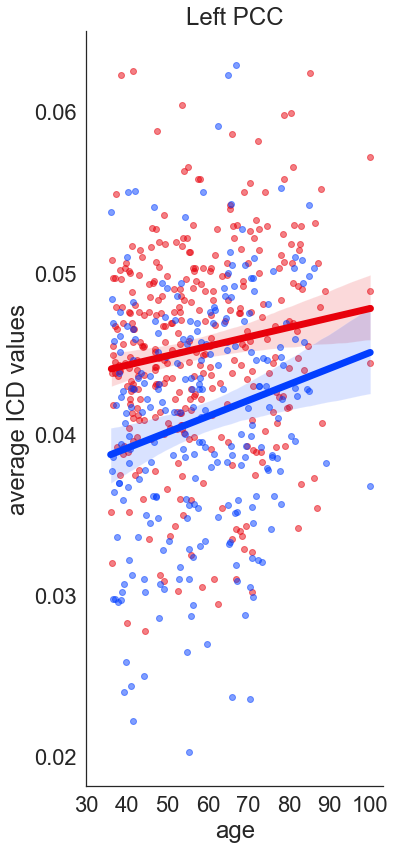

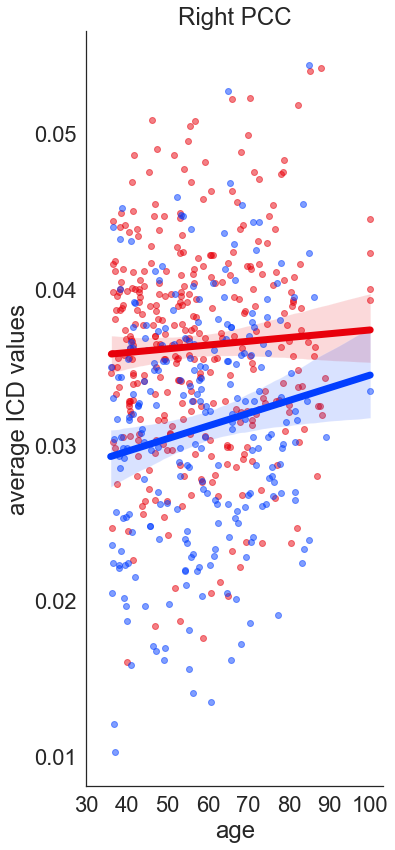

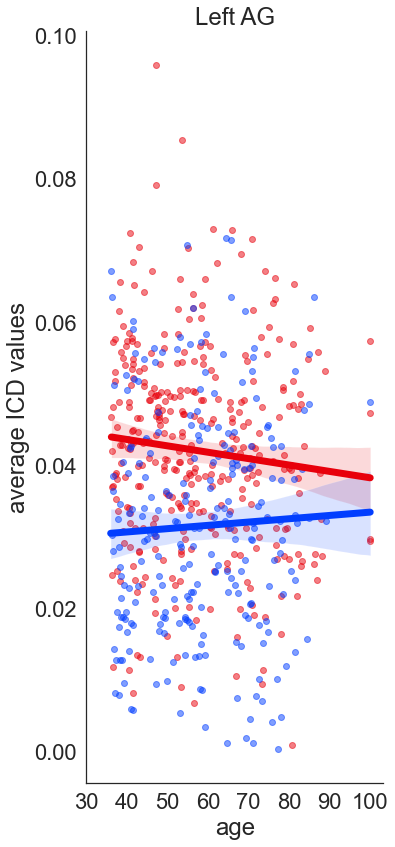

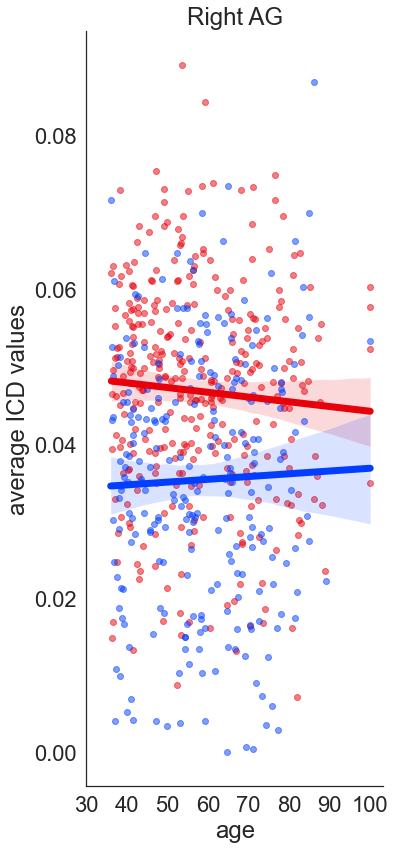

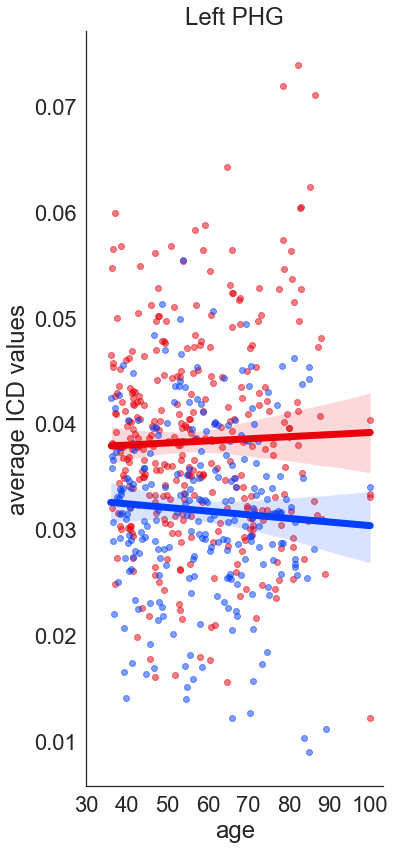

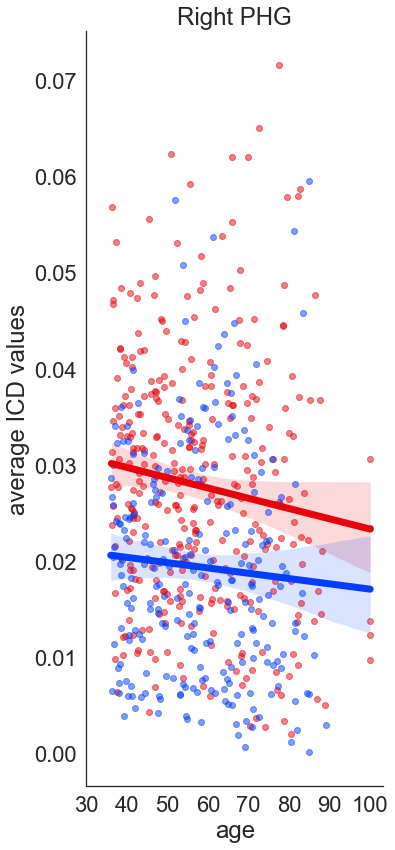

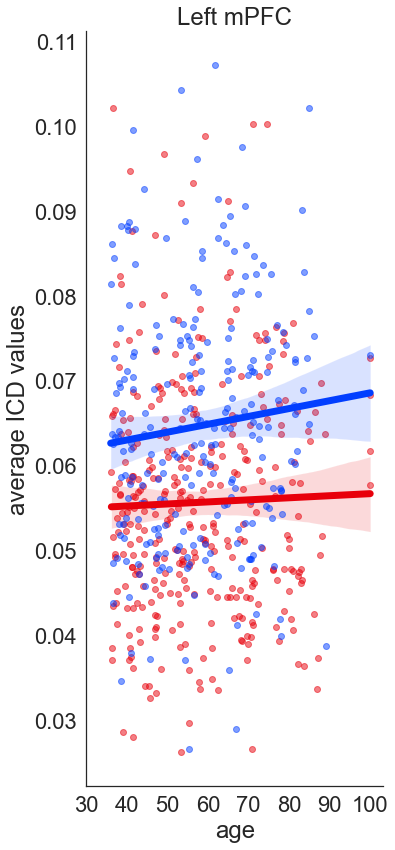

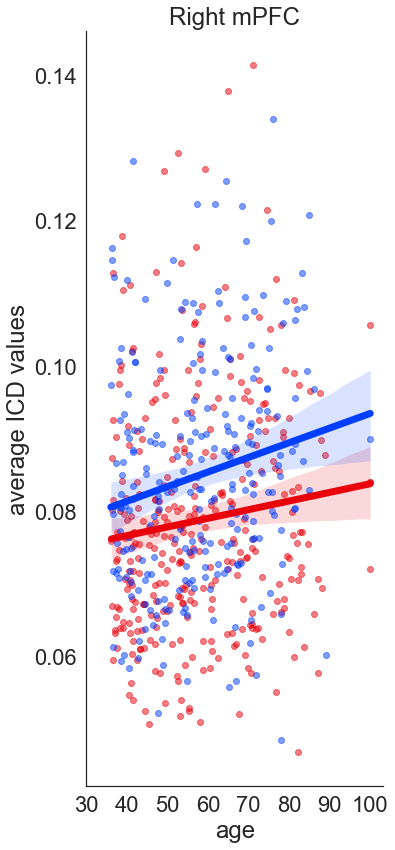

In [11]:
for i in interest_ROIs:
    conn_vs_age_plot(master_data_avg_icd, i, "avg", "icd")

### E. Get linear regression correlation info (R and p values) for each gender in each ROI

In [12]:
# create empty dataframe to store all linear and quadratic fits
lin_fits_icd = pd.DataFrame(columns = ['ROI_name', 'ROI_number', 
                                            'linear_R_F', 'linear_p_F','linear_R_M', 'linear_p_M'])

# fill dataframe with linear r and corresponding p values for all ROIs
for i in range(len(interest_ROIs)):
    lin_fits_icd = lin_fits_icd.append(get_lin_data(master_data_avg_icd, interest_ROIs[i], interest_ROI_nums[i], "avg", "icd"), ignore_index = True)

print(lin_fits_icd)

     ROI_name ROI_number  linear_R_F  linear_p_F  linear_R_M  linear_p_M
0    Left PCC         20    0.137991    0.010176    0.186548    0.003128
1   Right PCC         17    0.053287    0.323004    0.149391    0.018337
2     Left AG         21   -0.092777    0.084847    0.041480    0.514706
3    Right AG         18   -0.065074    0.227301    0.030436    0.632671
4    Left PHG          5    0.030377    0.573340   -0.058063    0.361570
5   Right PHG          6   -0.121930    0.023312   -0.066134    0.298586
6   Left mPFC         11    0.026363    0.625061    0.090614    0.153984
7  Right mPFC         10    0.111360    0.038418    0.178367    0.004756


### F. Generate boxplots with p-value annotations/mean trend lines

In [13]:
master_data_avg_icd = master_data_avg_icd[master_data_avg_icd["age"] <= 90]
master_data_avg_icd["age groups"] = pd.cut(master_data_avg_icd["age"], bins = range(30, 101, 10))

gender_list = sorted(master_data_avg_icd['gender'].unique())
age_group_list = sorted(master_data_avg_icd['age groups'].unique())

L_PCC_box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                 ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                 ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                 ((age_group_list[4], gender_list[0]), (age_group_list[4], gender_list[1]))]

R_PCC_box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                 ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                 ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                 ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                 ((age_group_list[4], gender_list[0]), (age_group_list[4], gender_list[1]))]

L_AngGyr_box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                    ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                    ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                    ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                    ((age_group_list[4], gender_list[0]), (age_group_list[4], gender_list[1])),]

R_AngGyr_box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                    ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                    ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                    ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                    ((age_group_list[4], gender_list[0]), (age_group_list[4], gender_list[1]))]

L_Frontal_box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                     ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                     ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                     ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                     ((age_group_list[5], gender_list[0]), (age_group_list[5], gender_list[1]))]

R_Frontal_box_pairs=[((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                     ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                     ((age_group_list[5], gender_list[0]), (age_group_list[5], gender_list[1]))]

L_PHG_box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                      ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                      ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                      ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                      ((age_group_list[4], gender_list[0]), (age_group_list[4], gender_list[1])),
                      ((age_group_list[5], gender_list[0]), (age_group_list[5], gender_list[1]))]

R_PHG_box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                      ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                      ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                      ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                      ((age_group_list[4], gender_list[0]), (age_group_list[4], gender_list[1]))]

all_box_pairs = [L_PCC_box_pairs, R_PCC_box_pairs, 
                 L_AngGyr_box_pairs, R_AngGyr_box_pairs,
                 L_PHG_box_pairs, R_PHG_box_pairs,
                 L_Frontal_box_pairs, R_Frontal_box_pairs]

### G. Finalize boxplot figure arrangement for paper (supplemental avg ICD boxplot figure)

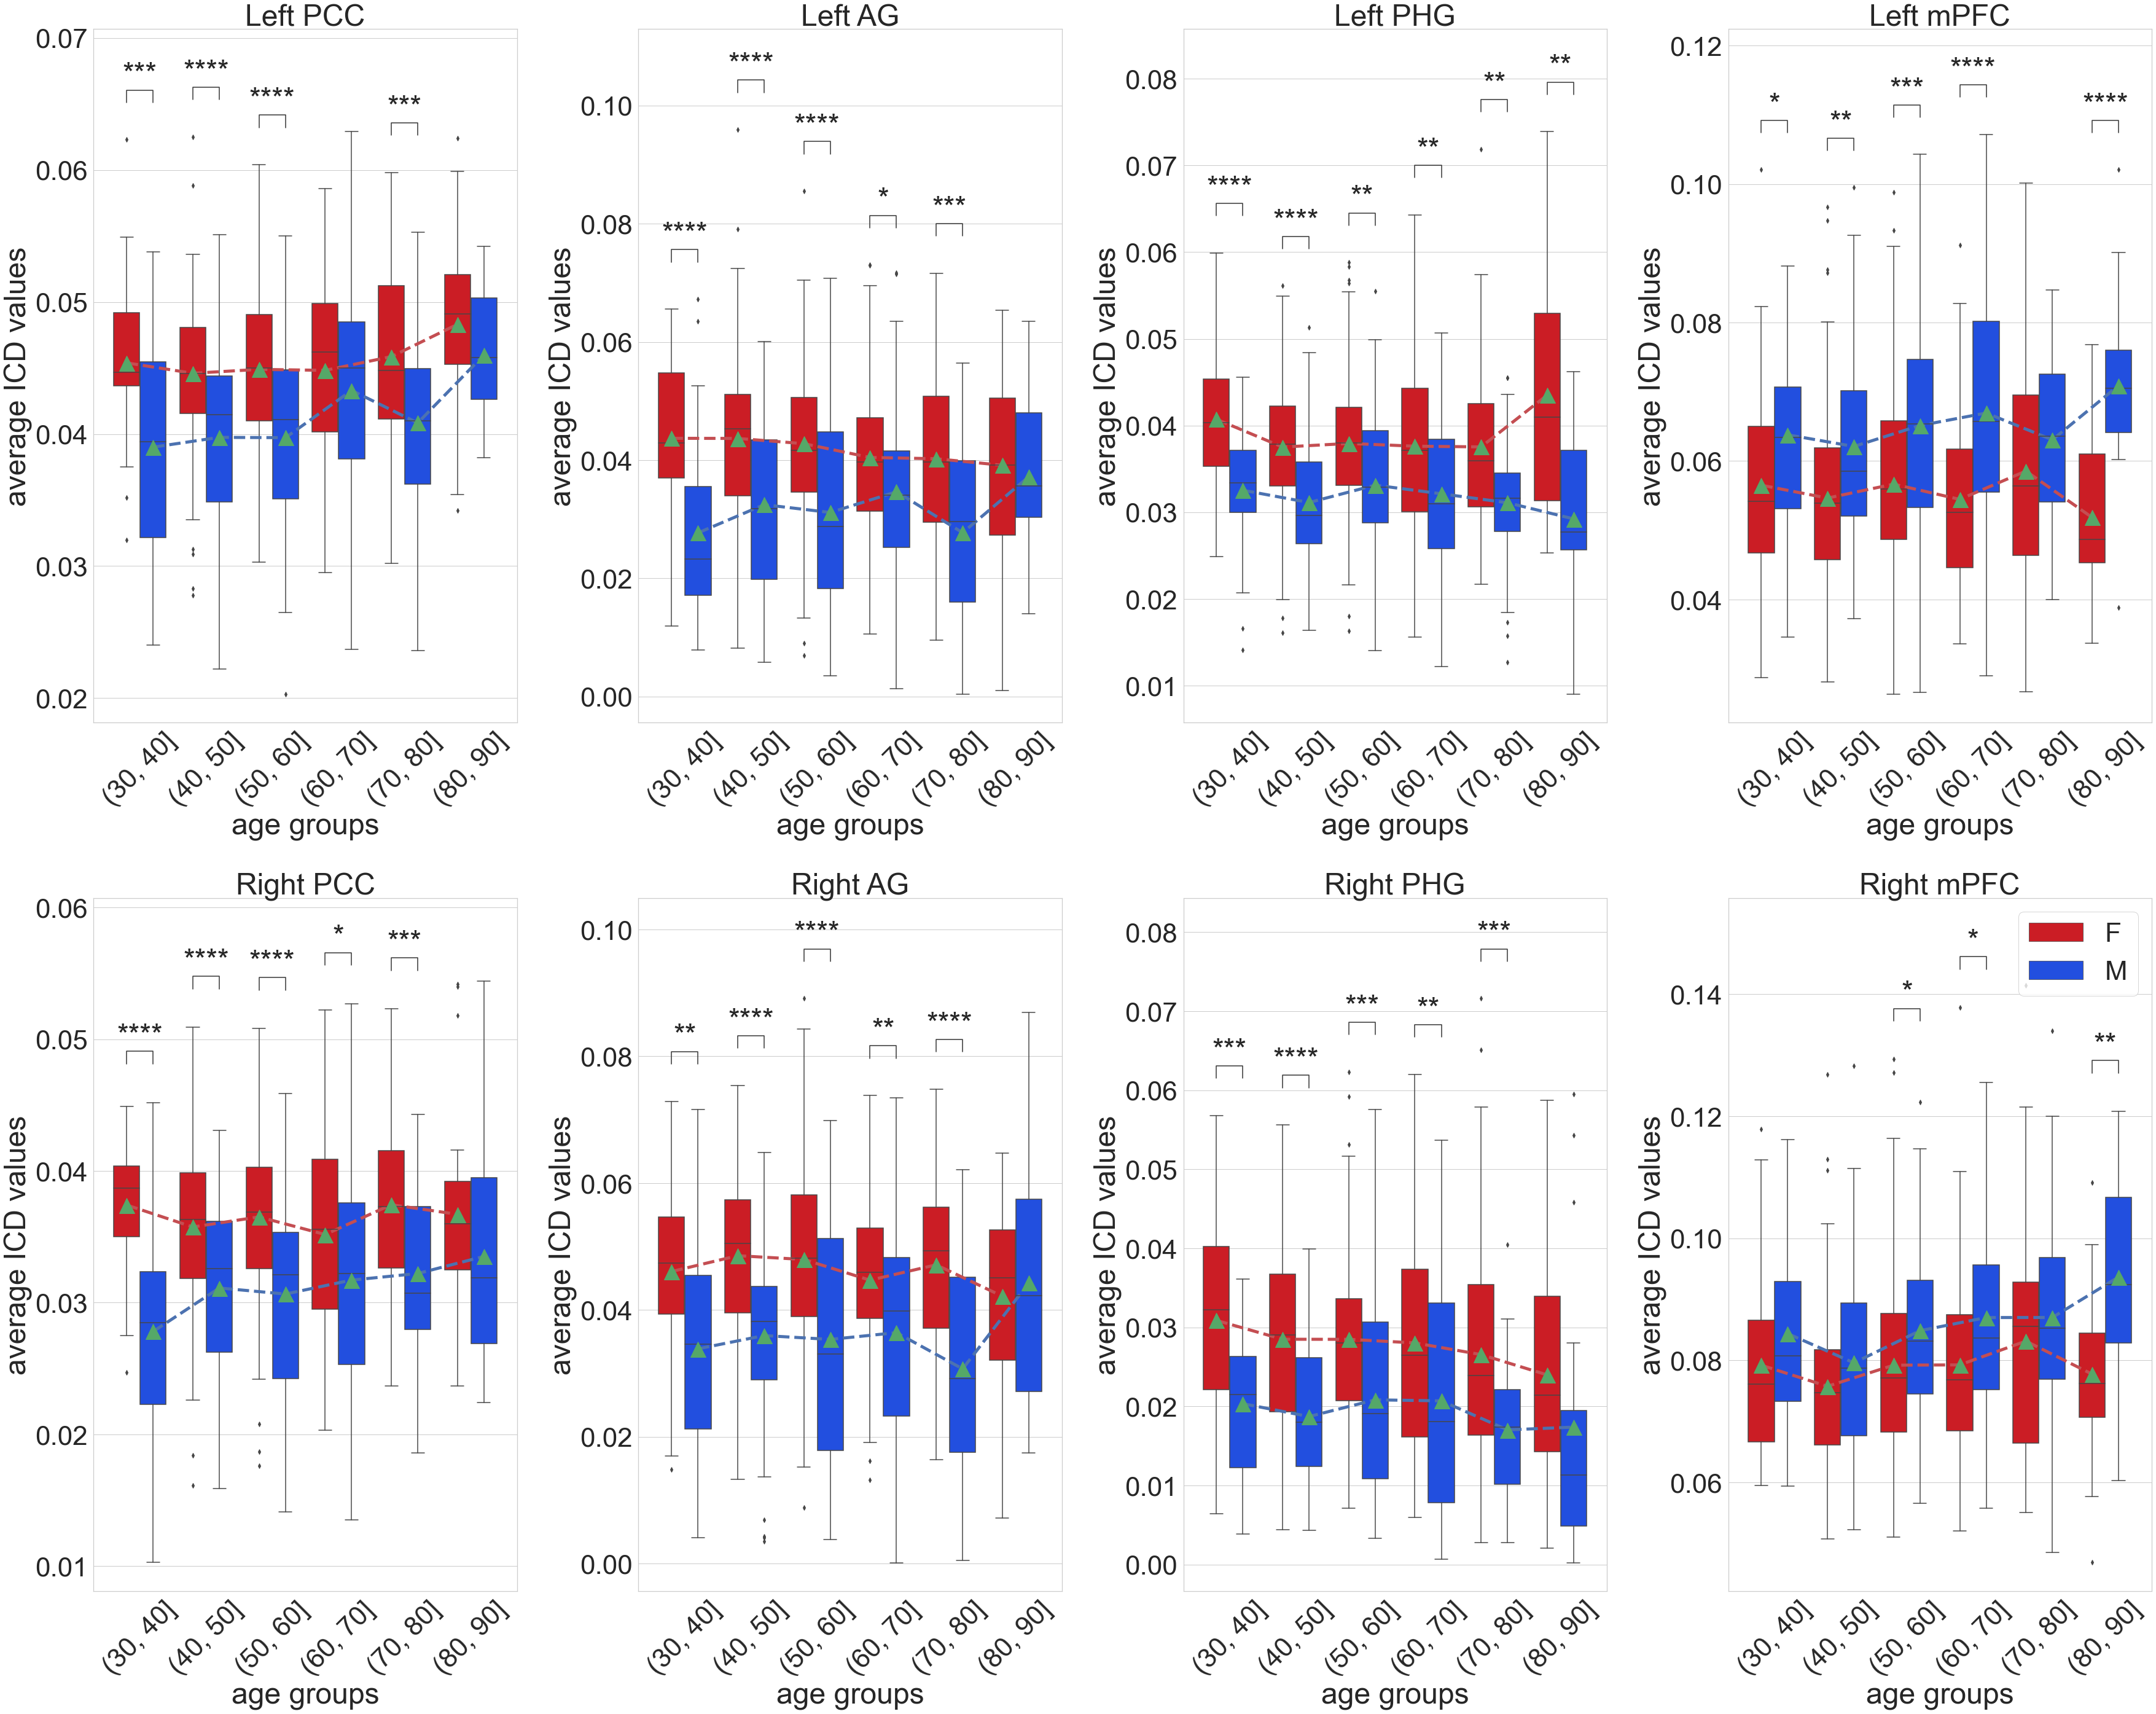

In [14]:
sns.set(font_scale = 4)
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize = [50,40])

for i in range(4):
    n = 241
    plt.subplot((n+i))
    conn_vs_age_boxplot(master_data_avg_icd, interest_ROIs[2*i], "icd", all_box_pairs[2*i])
    plt.subplot((n+i+4))
    conn_vs_age_boxplot(master_data_avg_icd, interest_ROIs[2*i+1], "icd", all_box_pairs[2*i+1])

plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig("figures/supp_icd_all_boxplots.png")

### H. Finalize boxplot figure arrangement for paper (main avg ICD boxplot figure)

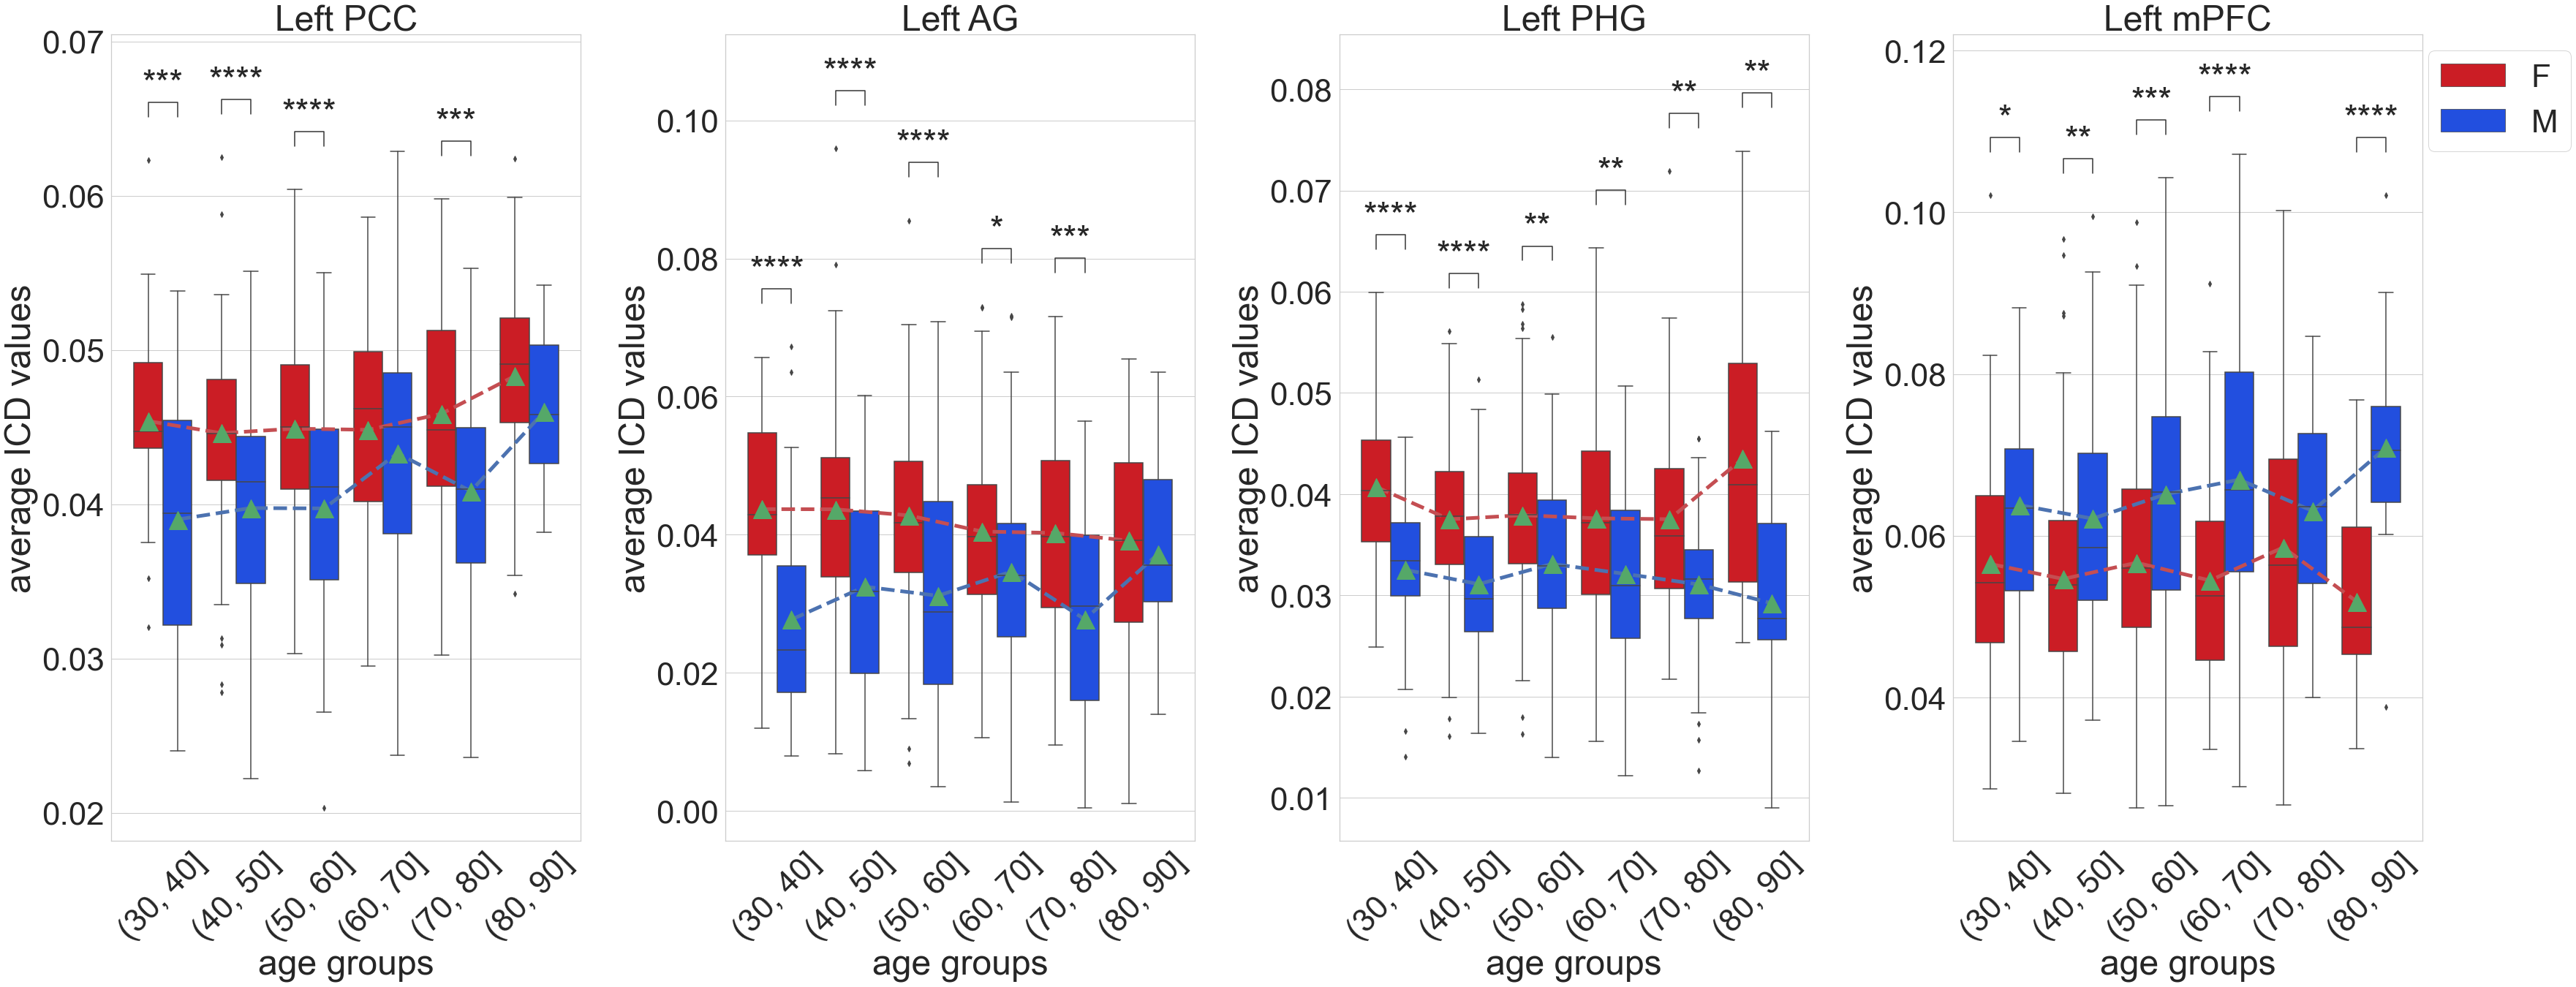

In [15]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize = [50,20])

for i in range(4):
    n = 141
    plt.subplot((n+i))
    conn_vs_age_boxplot(master_data_avg_icd, interest_ROIs[2*i], "icd", all_box_pairs[2*i])

plt.legend(loc='upper right', bbox_to_anchor=(1.35,1))

plt.tight_layout()
plt.savefig("figures/fig4_main_icd_all_boxplots.png")

### I. Perform t-test between women and men by decade and collect t scores and p values (performed without Bonferroni correction!)

In [16]:
ttest_icd = pd.DataFrame(columns = ['age groups', 'ROI', 't value', 'p value'])

for i in interest_ROIs:
    ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, i, "icd"))

# write all age groups and t-test values (stored in ttest_icd dataframe) into a .txt file
ttest_icd.to_csv('data/ttest_icd.txt')

### J. Generate heatmap of gender difference across ROI (still using t-score, but using monochrome color palette)

age groups     30-40     40-50     50-60     60-70     70-80     80-90
ROI                                                                   
Left PCC    3.825511  4.454953  4.522817  1.033571  3.587778  1.181180
Right PCC   5.666680  4.044174  4.667132  2.206621  3.855453  1.290808
Left AG     4.519083  4.449263  4.355679  2.112287  3.812894  0.427067
Right AG    3.262095  5.465353  4.422231  2.901320  5.037280  0.396493
Left PHG    4.205769  4.696041  3.095427  3.046188  3.365252  3.419171
Right PHG   3.719510  5.518074  3.665126  2.676812  3.481546  1.276876
Left mPFC   2.083220  3.182601  3.450061  4.405831  1.517020  4.928238
Right mPFC  1.332783  1.546244  2.028094  2.483548  1.048472  3.514362


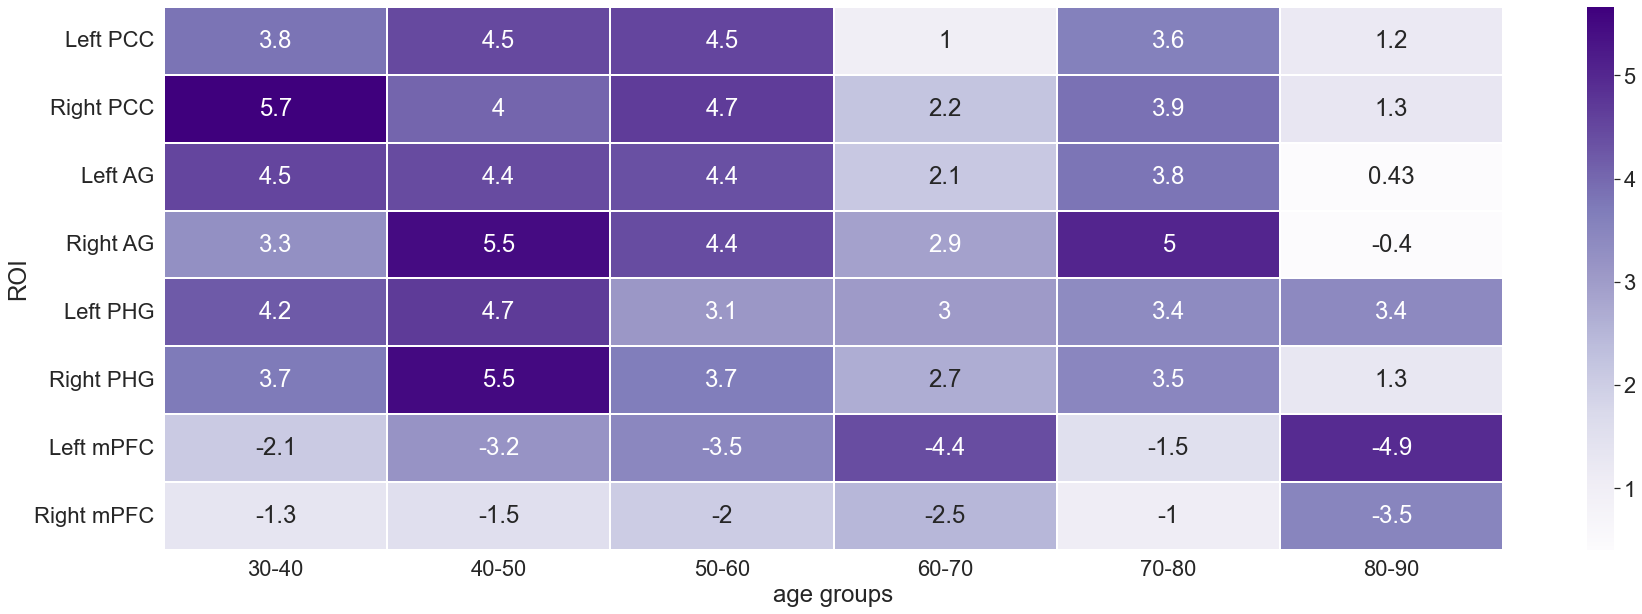

In [17]:
ttest_icd_new = ttest_icd[ttest_icd["age groups"] != "90-100"].pivot("ROI", "age groups", "t value")
ttest_icd_new = ttest_icd_new.reindex(index = interest_ROIs)
ttest_icd_new_absVal = ttest_icd_new

# save values from ttest_icd_new as array to manually assign heatmap annotations
heatmap_annot_val = ttest_icd_new.to_numpy()

ttest_icd_new_absVal = abs(ttest_icd_new_absVal)
print(ttest_icd_new_absVal)

sns.set(rc={"figure.figsize":(30,10)})
sns.set(font_scale = 2)
ax = sns.heatmap(ttest_icd_new_absVal, cmap = 'Purples', linewidth = 0.1, annot = heatmap_annot_val)
plt.savefig("figures/fig3_heatmap_ROIvsAge_tscores_monochrome.png")

### ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////